In [73]:
import polaris as po
import pandas as pd
import numpy as np
from  rdkit import Chem
from rdkit.Chem.Descriptors import MolWt
import seaborn as sns
from fastsolv import fastsolv
from sklearn.metrics import r2_score, mean_absolute_error

### 1. Download Datasets from Polaris

Get the Antiviral ADMET dataset from Polaris 

In [26]:
antiviral_admet_ds = po.load_dataset("asap-discovery/antiviral-admet-2025-unblinded")
antiviral_admet_ds.load_to_memory()
antiviral_admet_df = pd.DataFrame(antiviral_admet_ds.zarr_data).dropna(subset="KSOL")

[2025-08-19 19:57:29] INFO     The version of Polaris that was used to create the artifact          ]8;id=558010;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=173126;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/_artifact.py#92\92]8;;\
                               (0.11.8.dev4+g40e3b2b.d20250207) is different from the currently                    
                               installed version of Polaris (0.11.10).                                             

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=898257;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=836900;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/dataset/_base.py#181\181]8;;\
                               enough, consider caching the dataset first using DatasetV2.cache() for              
                               more performant data access.                                                        

[19:57:30]  Success: Fetching dataset                                                                 ]8;id=75727;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=729285;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/utils/context.py#53\53]8;;\

Get the Biogen dataset from Polaris

In [34]:
biogen_ds = po.load_dataset("biogen/adme-fang-v1")


[2025-08-19 20:00:22] INFO     The version of Polaris that was used to create the artifact (dev) is ]8;id=210923;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=840339;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/_artifact.py#92\92]8;;\
                               different from the currently installed version of Polaris (0.11.10).                

[2025-08-19 20:00:23] INFO     To verify the checksum, we need to recompute it. This can be slow    ]8;id=601500;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/mixins/_checksum.py\_checksum.py]8;;\:]8;id=448182;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/mixins/_checksum.py#67\67]8;;\
                               for large datasets.                                                                 

[20:00:23]  Success: Fetching dataset                                                                 ]8;id=835257;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=939853;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/utils/context.py#53\53]8;;\

### 2. Convert Units to LogS 

The Antiviral ADMET dataset has kinetic solubility in $\mu$M, we need to convert this to the log of molar solubility (LogS)

In [ ]:
antiviral_admet_df['LogS'] = np.log10(antiviral_admet_df.KSOL * 1e-6)

The Biogen dataset has solubility in log10($\mu$g/ml), we need to convert this to the log of molar solubility (LogS)

In [39]:
def ug_ml_to_logS(ug_ml, molar_mass):
    g_per_liter = ug_ml / 1000.0
    molar_solubility_S = g_per_liter / molar_mass
    log_S = np.log10(molar_solubility_S)
    return log_S

In [82]:
biogen_df = biogen_ds.table
biogen_df.dropna(subset="LOG_SOLUBILITY",inplace=True)
biogen_df['mol'] = biogen_df.SMILES.apply(Chem.MolFromSmiles)
biogen_df['ug_ml'] = 10**biogen_df.LOG_SOLUBILITY
biogen_df['MW'] = biogen_df.mol.apply(MolWt)

In [83]:
biogen_df['LogS'] = [ug_ml_to_logS(x,y) for x,y in biogen_df[["ug_ml","MW"]].values]

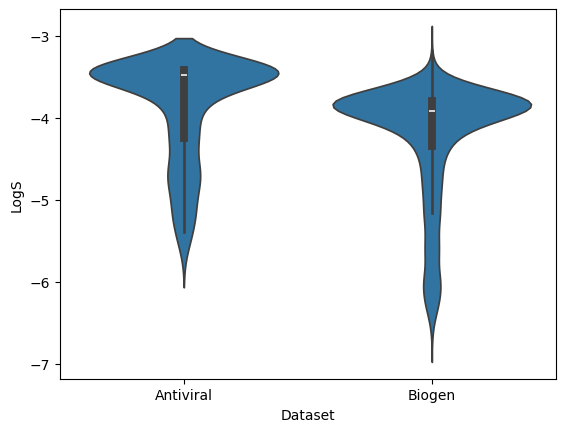

In [112]:
antiviral_admet_df['Dataset'] = "Antiviral"
biogen_df['Dataset'] = "Biogen"
cols = ['Dataset','LogS']
sns.violinplot(x='Dataset',y='LogS',data=pd.concat([antiviral_admet_df[cols],biogen_df[cols]]));

### 3. Evaluate fastsolv on the Antiviral ADMET dataset

A simple function at add the necessary columns for **fastsolv**

In [113]:
def prepare_dataframe(df,smiles_col):
    df['solute_smiles'] = df[smiles_col]
    df['solvent_smiles'] = "O"
    df['temperature'] = 298

Run fastsolv on the Antiviral ADMET dataset

In [114]:
prepare_dataframe(antiviral_admet_df,"CXSMILES")
antiviral_admet_pred = fastsolv(antiviral_admet_df)
antiviral_admet_df['predicted_LogS'] = antiviral_admet_pred.predicted_logS.values

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 447/447 [00:02<00:00, 151.19it/s]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Text(-5.5, -0.75, 'MAE = 1.47')

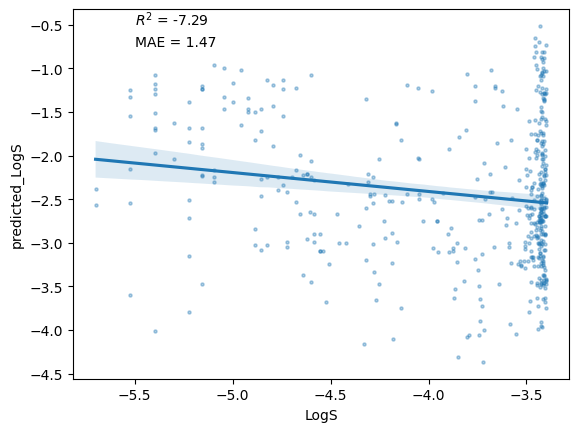

In [115]:
ax = sns.regplot(x="LogS",y="predicted_LogS",data=antiviral_admet_df,scatter_kws={"s": 5, "alpha" : 0.35})
r2 = r2_score(antiviral_admet_df.LogS,antiviral_admet_df.predicted_LogS)
mae = mean_absolute_error(antiviral_admet_df.LogS,antiviral_admet_df.predicted_LogS)
ax.text(-5.5, -0.5, f"$R^2$ = {r2:.2f}")
ax.text(-5.5, -0.75, f"MAE = {mae:.2f}")

### 4. Evaluate fastsolv on the Biogen dataset

In [116]:
prepare_dataframe(biogen_df,"SMILES")
biogen_pred = fastsolv(biogen_df)
biogen_df['predicted_LogS'] = biogen_pred.predicted_logS.values

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [00:09<00:00, 223.02it/s]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

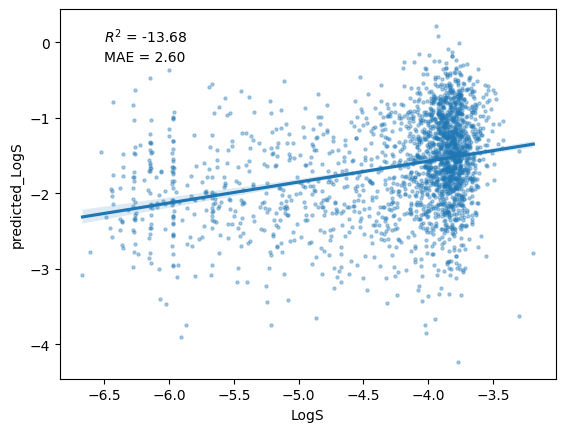

In [98]:
ax = sns.regplot(x="LogS",y="predicted_LogS",data=biogen_df,scatter_kws={"s": 5, "alpha" : 0.35})
r2 = r2_score(biogen_df.LogS,biogen_df.predicted_LogS)
mae = mean_absolute_error(biogen_df.LogS,biogen_df.predicted_LogS)
ax.text(-6.5, 0.0, f"$R^2$ = {r2:.2f}")
ax.text(-6.5, -0.25, f"MAE = {mae:.2f}");

In [121]:
biogen_df

,UNIQUE_ID,MOL_smiles,SMILES,LOG_HLM_CLint,LOG_RLM_CLint,LOG_MDR1-MDCK_ER,LOG_HPPB,LOG_RPPB,LOG_SOLUBILITY,mol,MW,sol_ug_ml,ug_ml,LogS,solute_smiles,solvent_smiles,temperature,predicted_LogS,Dataset
0,b5e1231aef0080c76b4207ca1355485432877339,Brc1cc2c(cc1Cn1cncn1)OCCCO2,Brc1cc2c(cc1Cn1cncn1)OCCCO2,0.886265,2.357933,-0.247518,NaN,NaN,1.536432,<rdkit.Chem.rdchem.Mol object at 0x150117f40>,310.151,34.390,34.390,-3.955141,Brc1cc2c(cc1Cn1cncn1)OCCCO2,O,298,-1.341322,Biogen
1,0604cf74e44450d5963d169e18854d96c4e5dba8,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,0.675687,1.613704,-0.010669,NaN,NaN,1.797475,<rdkit.Chem.rdchem.Mol object at 0x150187f40>,345.156,62.730,62.730,-3.740540,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,O,298,-2.414264,Biogen
3,9be43035e7b8a5078babf4345584f4dc6dcd1448,Brc1cnc2ccccc2c1,Brc1cnc2ccccc2c1,NaN,NaN,NaN,NaN,NaN,-0.033858,<rdkit.Chem.rdchem.Mol object at 0x150187ed0>,208.058,0.925,0.925,-5.352043,Brc1cnc2ccccc2c1,O,298,-1.294908,Biogen
5,70ac5fbe7181b1fce36dbaedaedcd3cdeb4fdf82,C#CCN1CCC(c2nc(Cc3noc(C)n3)no2)CC1,C#CCN1CCC(c2nc(Cc3noc(C)n3)no2)CC1,0.675687,1.107108,-0.135635,NaN,NaN,1.695044,<rdkit.Chem.rdchem.Mol object at 0x150187e60>,287.323,49.550,49.550,-3.763327,C#CCN1CCC(c2nc(Cc3noc(C)n3)no2)CC1,O,298,-1.561687,Biogen
6,e9cafc1522a01017509e0fda082d84676cdc1f5e,C#CCN1CCC[C@H]1C(=O)Nc1cnn(-c2ncccn2)c1,C#CCN1CCC[C@H]1C(=O)Nc1cnn(-c2ncccn2)c1,0.675687,1.921166,0.596581,NaN,NaN,1.653984,<rdkit.Chem.rdchem.Mol object at 0x150187df0>,296.334,45.080,45.080,-3.817798,C#CCN1CCC[C@H]1C(=O)Nc1cnn(-c2ncccn2)c1,O,298,-1.749381,Biogen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3511,6b39954041ed15e815bc15457e06440183006a00,c1cncc(-c2ccnn2CN2CCOCC2)c1,c1cncc(-c2ccnn2CN2CCOCC2)c1,NaN,NaN,NaN,NaN,NaN,1.239049,<rdkit.Chem.rdchem.Mol object at 0x150131e70>,244.298,17.340,17.340,-4.148871,c1cncc(-c2ccnn2CN2CCOCC2)c1,O,298,-1.242087,Biogen
3513,d08dfa20c576ef45061fd2af3a1c7acc286bc6d2,c1cnn(-c2ccc(-c3ccc(NC4CC4)nn3)cc2)c1,c1cnn(-c2ccc(-c3ccc(NC4CC4)nn3)cc2)c1,NaN,NaN,NaN,NaN,NaN,-0.107905,<rdkit.Chem.rdchem.Mol object at 0x150131ee0>,277.331,0.780,0.780,-5.550904,c1cnn(-c2ccc(-c3ccc(NC4CC4)nn3)cc2)c1,O,298,-1.602266,Biogen
3514,c9bf3aca6d10ff3538ce617d83b9de8c80723024,c1csc(-c2csc3nc(CN4CCOCC4)nc(N4CCc5[nH]ncc5C4)...,c1csc(-c2csc3nc(CN4CCOCC4)nc(N4CCc5[nH]ncc5C4)...,2.747507,3.118970,1.921635,NaN,NaN,1.690107,<rdkit.Chem.rdchem.Mol object at 0x150131f50>,438.582,48.990,48.990,-3.951943,c1csc(-c2csc3nc(CN4CCOCC4)nc(N4CCc5[nH]ncc5C4)...,O,298,-2.662541,Biogen
3517,644313d1941ab4550760b7c1162c54d209a7435f,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,1.240899,1.906157,0.094514,NaN,NaN,1.749891,<rdkit.Chem.rdchem.Mol object at 0x150131fc0>,274.393,56.220,56.220,-3.688482,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,O,298,-1.360543,Biogen
